In [1]:
import os
import cv2
import numpy as np
import habitat
from env import Env
import quaternion
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/envs/habitat/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/envs/habitat/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/envs/habitat/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/envs/habitat/lib/python3.6/site-packages/tensor

In [2]:
!ln -s /data/ ./data

ln: failed to create symbolic link './data/data': File exists


In [3]:
from arguments import init_config
config = init_config()

In [4]:
print(config.SIMULATOR.FORWARD_STEP_SIZE)

0.25


In [5]:
config.defrost()
config.SIMULATOR.RGB_SENSOR.NOISE_MODEL_KWARGS.intensity_constant = 0.  # 0.1
config.SIMULATOR.NOISE_MODEL.NOISE_MULTIPLIER = 0.  # 0.5
config.SIMULATOR.TURN_ANGLE = 5  # 10
config.SIMULATOR.TILT_ANGLE = 5  # 10
config.SIMULATOR.FORWARD_STEP_SIZE = 0.125  # 0.25
config.freeze()

In [6]:
config['DATASET']['DATA_PATH'] = '/data/v1/{split}/{split}.json.gz'
config['DATASET']['SCENES_DIR'] = '/data'
config['DATASET']['SPLIT'] = 'train'
env = Env(config=config)
print("Environment creation successful")

2020-06-03 14:24:18,798 Initializing dataset PointNav-v1
2020-06-03 14:29:03,113 initializing sim Sim-v0
2020-06-03 14:29:14,581 Initializing task Nav-v0


Environment creation successful


In [7]:
res = env.reset()[0]

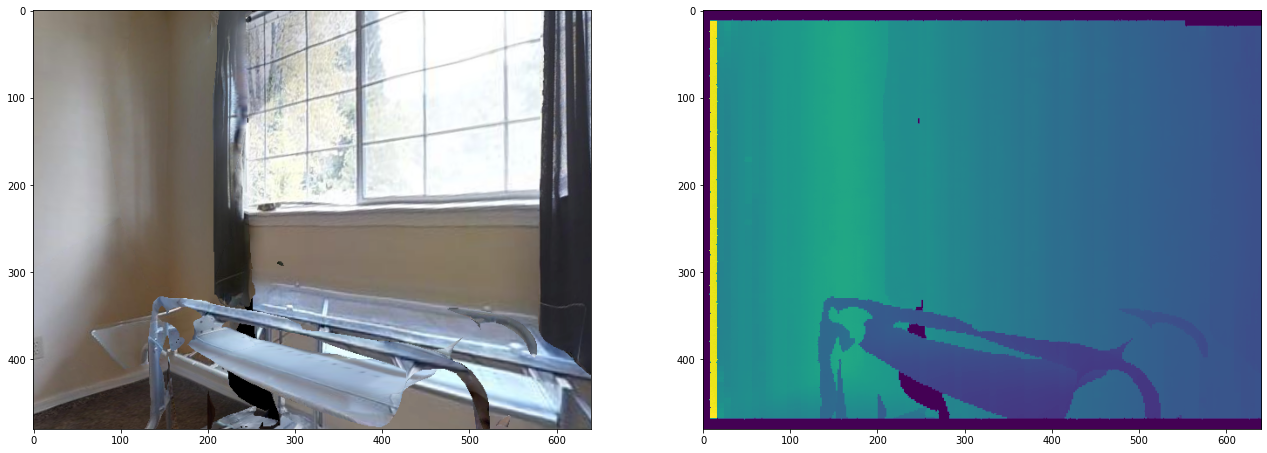

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(22, 10))
plt.subplot(121)
plt.imshow(res['rgb'])
plt.subplot(122)
plt.imshow(res['depth'][:,:,0])
plt.show()

Step #1:
--gps: [0. 0.]
--pos: [3.2487120628356934, 1.6385549306869507]
--compass: [-0.17453292]


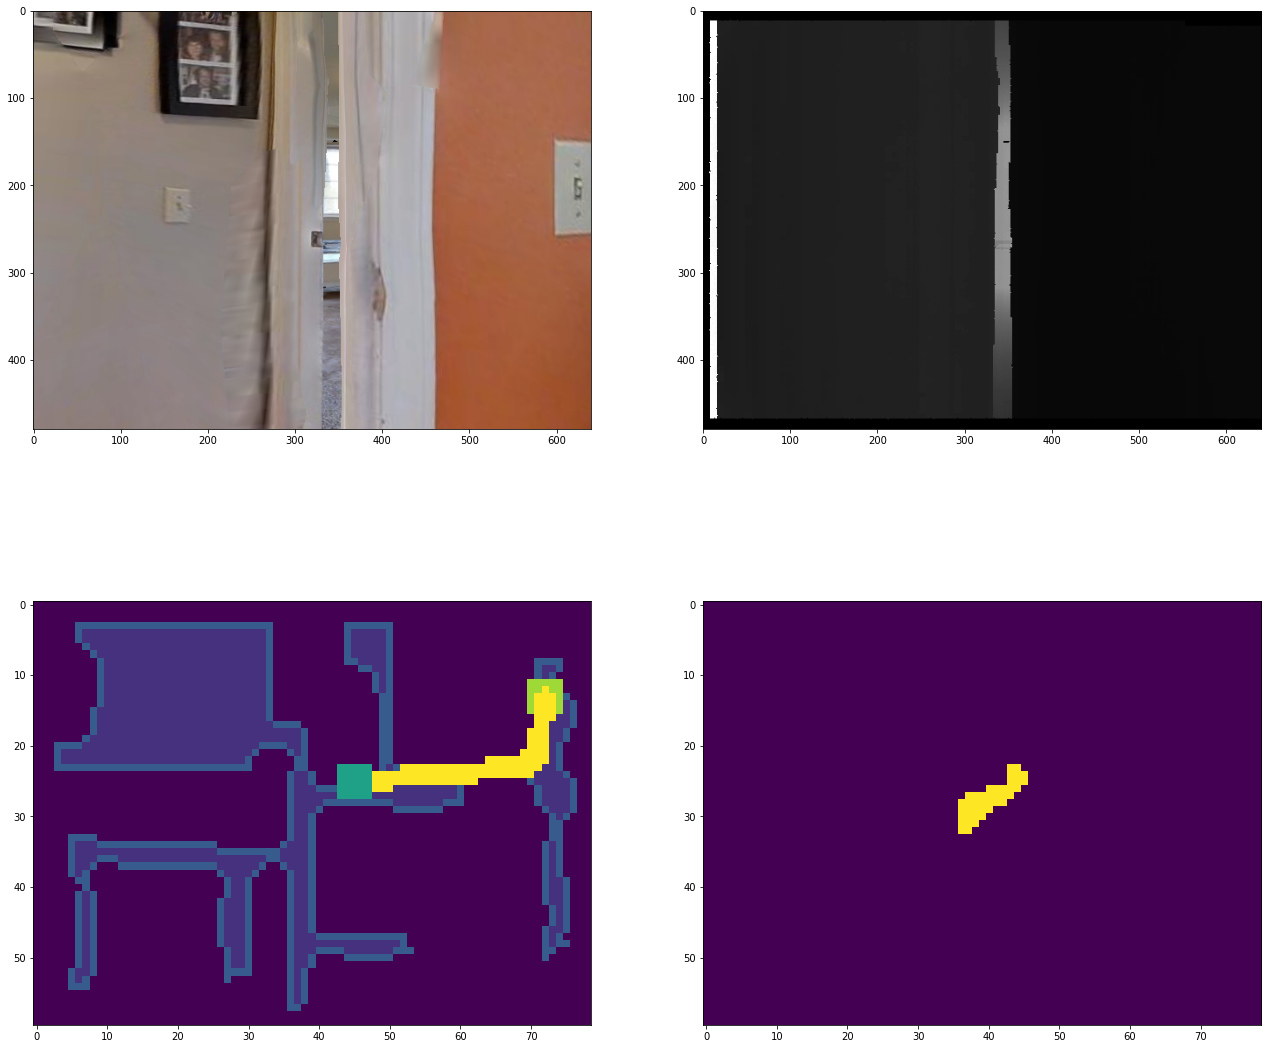

In [9]:
res = env.reset()[0]
done = False
ind = 0
while not done:
    observations, info, done = env.step(0, ideal_action=True)
    ind += 1
    print('Step #{}:\n--gps: {}\n--pos: {}\n--compass: {}'.format(ind, observations['gps'], observations['pos'], observations['compass']))
    
    fig, ax = plt.subplots(2, 2, figsize=(22, 20))
    plt.subplot(221)
    plt.imshow(observations['rgb'])
    plt.subplot(222)
    plt.imshow(observations['depth'][:,:,0], cmap='gray')
    plt.subplot(223)
    plt.imshow(info['top_down_map']['map'])
    plt.subplot(224)
    plt.imshow(info['top_down_map']['fog_of_war_mask'])
    plt.show()
    break

In [15]:
def q_to_axisangle(q):
    # from quaternion to vector of rotation and angle of rotation
    w, v = q.a.real, (q.x, q.y, q.z)
    theta = np.arccos(w) * 2.0
    return theta * 180. / np.pi % 360.

In [7]:
seq_num = 5
save_path = '/root/DF-VO/dataset/custom'

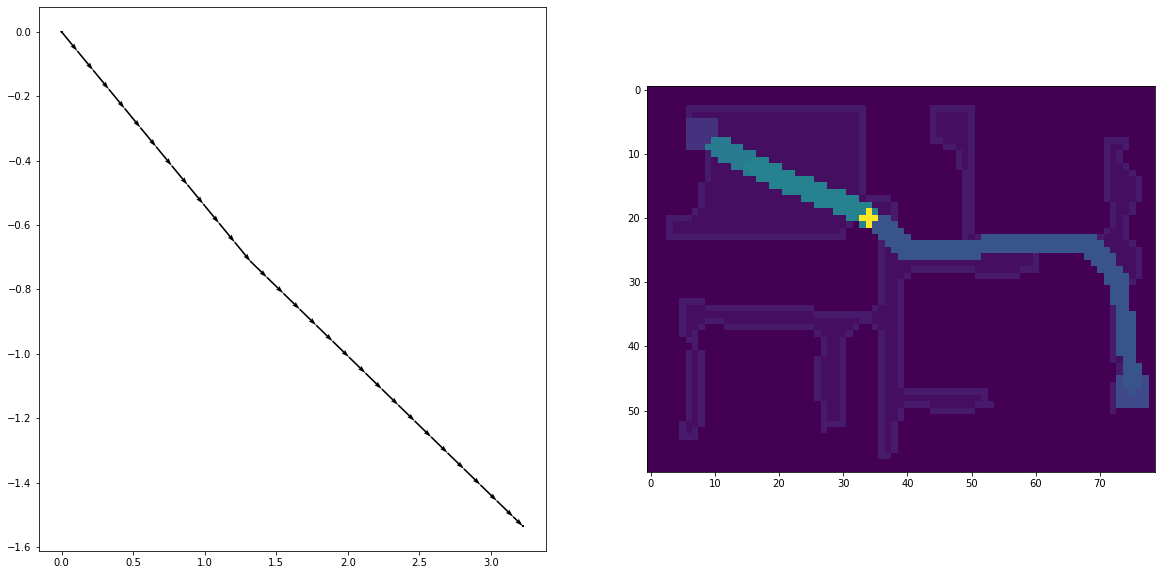

KeyboardInterrupt: 

In [18]:
add_redun = 0
show_images = False
show_path = True
assert add_redun >= 0

!cd $save_path
seq_path = os.path.join(save_path, str(seq_num))
!mkdir $seq_path
rgb_path = os.path.join(seq_path, 'rgb')
depth_path = os.path.join(seq_path, 'depth')
!mkdir $rgb_path
!mkdir $depth_path

done = False
res = env.reset()[0]
pos_start = env.sim.get_agent_state().position
# pos_start = np.zeros(3).astype(np.float32)
w, x, y, z = env.sim.get_agent_state().rotation.components
# q_rev = quaternion.quaternion(w,-x,-y,-z) / (w*w + x*x + y*y + z*z)
# global_rot = quaternion.quaternion(1,0,1,0) * q_rev
ind = 0
observations = env.sim.get_observations_at()
cv2.imwrite(os.path.join(rgb_path, '{:.06f}.png'.format(ind)), observations['rgb'])
cv2.imwrite(os.path.join(depth_path, '{:.06f}.png'.format(ind)), observations['depth']*255)
with open(os.path.join(seq_path, 'rgb.txt'), 'a') as f:
    f.write('{} {:.06f}.png\n'.format(ind, ind))
with open(os.path.join(seq_path, 'depth.txt'), 'a') as f:
    f.write('{} {:.06f}.png\n'.format(ind, ind))
with open(os.path.join(seq_path, 'groundtruth.txt'), 'a') as f:
    pos = env.sim.get_agent_state().position - pos_start
#     q = global_rot * env.sim.get_agent_state().rotation
    q = env.sim.get_agent_state().rotation
    f.write('{} {} {} {} {} {} {} {}\n'.format(ind, pos[2], pos[1], pos[0], q.x, q.y, q.z, q.w))    

path_x = np.array([pos[2]])
path_y = np.array([pos[0]])

while not done:
    if not ind % (add_redun + 1):
        observations, info, done = env.step(0, ideal_action=True)
    else:
        action = np.random.randint(1, 4)
        observations, info, done = env.step(action, ideal_action=False)
    ind += 1
    cv2.imwrite(os.path.join(rgb_path, '{:.06f}.png'.format(ind)), observations['rgb'])
    cv2.imwrite(os.path.join(depth_path, '{:.06f}.png'.format(ind)), observations['depth']*255)
    with open(os.path.join(seq_path, 'rgb.txt'), 'a') as f:
        f.write('{} {:.06f}.png\n'.format(ind, ind))
    with open(os.path.join(seq_path, 'depth.txt'), 'a') as f:
        f.write('{} {:.06f}.png\n'.format(ind, ind))
    with open(os.path.join(seq_path, 'groundtruth.txt'), 'a') as f:
        pos = env.sim.get_agent_state().position - pos_start
        # q = global_rot * env.sim.get_agent_state().rotation
        q = env.sim.get_agent_state().rotation
        f.write('{} {} {} {} {} {} {} {}\n'.format(ind, pos[2], pos[1], pos[0], q.x, q.y, q.z, q.w))
    path_x = np.append(path_x, pos[2])
    path_y = np.append(path_y, pos[0])
    if show_path and not ind % 10 and not show_images:
        clear_output(True)
        fig, ax = plt.subplots(1, 2, figsize=(20,10))
        plt.subplot(121)
        plt.quiver(path_x[:-1], path_y[:-1], path_x[1:]-path_x[:-1],
                   path_y[1:]-path_y[:-1], scale_units='xy', angles='xy', scale=1.)
        plt.subplot(122)
        plt.imshow(info['top_down_map']['map'])
        plt.show()
    if show_images:
        clear_output(True)
        fig, ax = plt.subplots(1, 2, figsize=(20,10))
        fig.suptitle('#{}:\npos: ({:.6} {:.6} {:.6})\nrot: ({:.4} {:.4} {:.4} {:.4})\nang: {}'.format(ind, *pos, q.x, q.y, q.z, q.w, q_to_axisangle(q)))
        plt.subplot(121)
        plt.imshow(observations['rgb'])
        plt.subplot(122)
        # plt.xlim([-1,1])
        # plt.ylim([-1,1])
        plt.quiver(path_x[:-1], path_y[:-1], path_x[1:]-path_x[:-1],
                   path_y[1:]-path_y[:-1], scale_units='xy', angles='xy', scale=1.)
        # plt.plot(path_x, path_y, '.r-')
        plt.show()

if show_path:
    clear_output(True)
    fig, ax = plt.subplots(1, 2, figsize=(20,10))
    plt.subplot(121)
    plt.quiver(path_x[:-1], path_y[:-1], path_x[1:]-path_x[:-1],
               path_y[1:]-path_y[:-1], scale_units='xy', angles='xy', scale=1.)
    plt.subplot(122)
    plt.imshow(info['top_down_map']['map'])
    plt.show()

seq_num += 1